In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from IPython import display
import datetime
import time
import geopandas as gpd
import math

import glob
import datashader as ds
from shapely import wkt
from pyproj import Transformer
from shapely.geometry import box
import spatialpandas as sp
import cv2
from tqdm.notebook import trange, tqdm
from matplotlib.colors import LinearSegmentedColormap

from utils import *
from deep_shadow import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
_gt = pd.read_csv('./data/shadows/_parks/nyc-summer.csv')
_pred = pd.read_csv('./data/shadows_new/_parks/nyc-summer.csv')

In [7]:
# convert to gdf and plot
gdf_gt = gpd.GeoDataFrame(_gt, crs='EPSG:4326', geometry=_gt['geometry'].apply(wkt.loads))
gdf_gt = gdf_gt.to_crs('EPSG:3395')
# gdf_gt['geometry'] = gdf_gt['geometry'].apply(lambda x: x.buffer(5))

In [8]:
gdf_pred = gpd.GeoDataFrame(_pred, crs='EPSG:4326', geometry=_pred['geometry'].apply(wkt.loads))
gdf_pred = gdf_pred.to_crs('EPSG:3395')
# gdf_pred['geometry'] = gdf_pred['geometry'].apply(lambda x: x.buffer(5))

In [9]:
transformer = Transformer.from_crs(3395, 4326)
invtransformer = Transformer.from_crs(4326,3395)

def deg2num(lat_deg, lon_deg, zoom):
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = ((lon_deg + 180.0) / 360.0 * n)
    ytile = ((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    return (xtile, ytile)

def num2deg(xtile, ytile, zoom):
    n = 2.0 ** zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
    lat_deg = math.degrees(lat_rad)
    return (lat_deg, lon_deg)

In [10]:
i, j = 19262, 24684
bb0 = num2deg(i,j,16)
bb1 = num2deg(i+1,j+1,16)

bb0 = invtransformer.transform(bb0[0],bb0[1])
bb1 = invtransformer.transform(bb1[0],bb1[1])

bbox = box(bb0[0],bb0[1],bb1[0],bb1[1])

<Axes: >

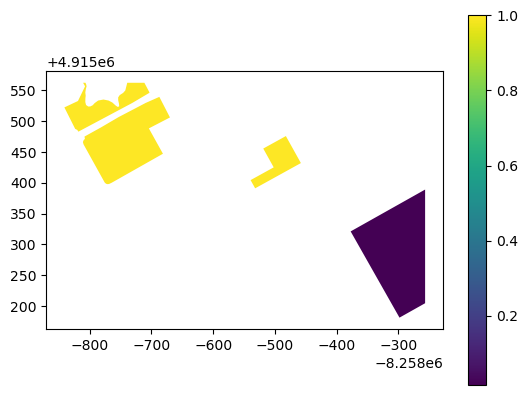

In [37]:
parks = gdf_gt.loc[gdf_gt.sindex.intersection(bbox.bounds)]

proxy = pd.DataFrame({'geometry': bbox}, index=[parks.size])
proxy = gpd.GeoDataFrame(proxy)
proxy.crs = '3395'

clipped = gpd.clip(parks, proxy)
clipped.plot(column='max', legend=True)

In [42]:
clipped['mean'].mean()

0.08922360010453301

<Axes: >

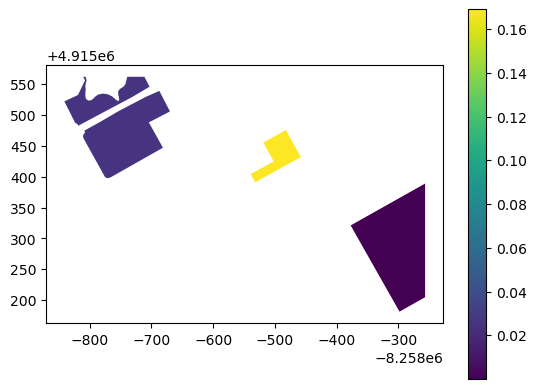

In [12]:
parks = gdf_pred.loc[gdf_gt.sindex.intersection(bbox.bounds)]

proxy = pd.DataFrame({'geometry': bbox}, index=[parks.size])
proxy = gpd.GeoDataFrame(proxy)
proxy.crs = '3395'

clipped = gpd.clip(parks, proxy)
clipped.plot(column='mean', legend=True)

In [49]:
i, j = 19262, 24684

height = cv2.imread('%s/%s/%d/%d/%d.png'%(height_path, 'nyc', zoom, i, j), cv2.IMREAD_GRAYSCALE)
img_park = cv2.imread('%s/%s/%d/%d/%d.png' % (parks_path, 'nyc', zoom, i, j), cv2.IMREAD_GRAYSCALE)
img_gt = cv2.imread('%s/%s-%s/%d/%d/%d.png' % (ground_truth_path, 'nyc', date, zoom, i, j), cv2.IMREAD_GRAYSCALE)
img_pred = cv2.imread('%s/%s-%s/%d/%d/%d.png' % (shadow_path, 'nyc', date, zoom, i, j), cv2.IMREAD_GRAYSCALE)

# normalize all images to 0-1
height = height / 255.0
img_park = img_park / 255.0
img_gt = img_gt / 255.0
img_pred = img_pred / 255.0

img_gt = np.where(height > 0, 0, img_gt)

# plt.imshow(img_pred)
# plt.show()

# img_pred = np.where(img_park > 0, img_pred, 0)

if np.sum(img_pred) != 0:
    # img_gt = np.where(img_park > 0, img_gt, 0)
    # get the mean of shadow for img_park only for non-zero pixels
    print(np.count_nonzero(img_park))
    print(np.sum(img_pred))
    mean = np.sum(img_pred) / np.count_nonzero(img_park)
    print(mean)

# plt.imshow(img_pred)
# plt.show()

# plt.imshow(img_park)
# plt.show()

5671
9316.792156862744
1.642883469734217


In [13]:
clipped

,Unnamed: 0,min,max,mean,count,sum,median,nodata,area,name,geometry
209,33971542,0.0,0.003922,0.000006,4277,0.023529,0.000000,0,14031.142570,Arbutus Woods Park,"POLYGON ((-8258298.062 4915181.475, -8258377.2..."
1330,247143605,0.0,0.756863,0.169048,485,81.988235,0.145098,0,1590.260835,NaN,"POLYGON ((-8258501.921 4915425.023, -8258518.8..."
72,12313231,0.0,0.603922,0.025491,2937,74.866667,0.000000,0,9642.535604,Huguenot Ponds Park,"MULTIPOLYGON (((-8258704.478 4915548.755, -825..."


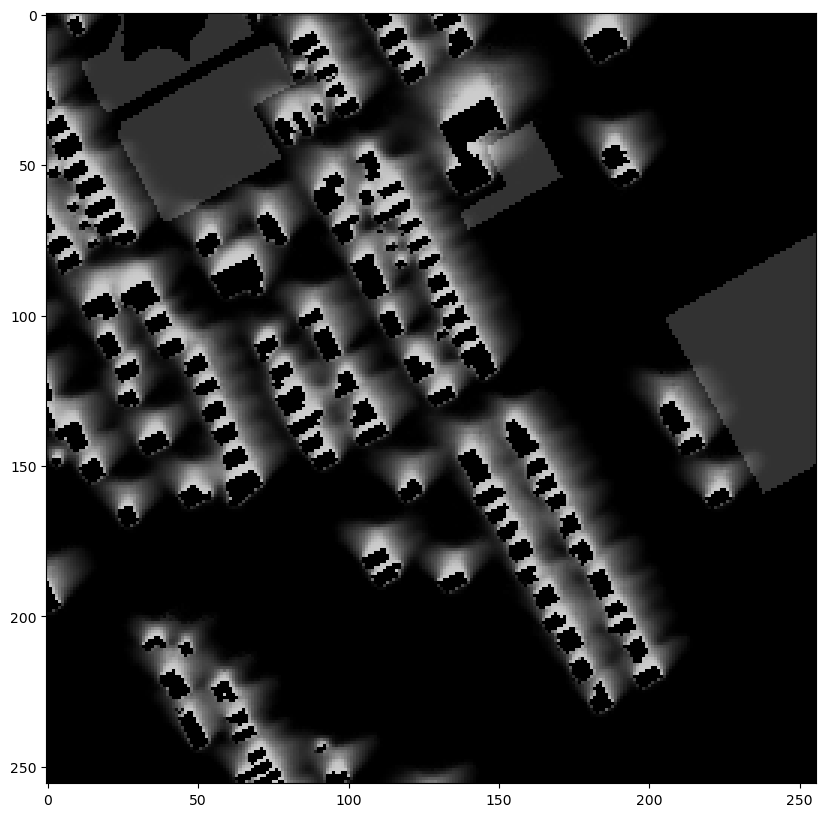

In [35]:
plt.figure(figsize=(10,10))
# load './data/shadows_new/nyc-winter/16/19265/24681.png'
shadows = cv2.imread('./data/shadows_new/nyc-winter/16/19262/24684.png')
parks = cv2.imread('./data/parks_tile/nyc/16/19262/24684.png')

plt.imshow(shadows, cmap='Reds')
plt.imshow(parks, cmap='gray', alpha=0.2)

In [15]:
def get_all_tiles(height_path, shadow_path, cities, dates, zoom):
    def get_path(row, city, date):
        values = [height_path, shadow_path, city, date,
                  '%d/%d/%d.png' % (row['zoom'], row['i'], row['j'])]
        for i in range(0, 9):
            values.append(str(row[str(i)]))
        return values

    all_dataset = []
    for city in cities:
        for date in dates:
            df = pd.read_csv('data/evaluation/%s-%s-%d.csv' %
                             (city, date, zoom))
            ds = df.apply(get_path, args=(city, date), axis=1).tolist()
            all_dataset.extend(ds)

    return all_dataset

In [16]:
height_path = './data/heights_new/'
shadow_path = './data/shadows/'

BATCH_SIZE = 1
test_cities = ['dc', 'nyc', 'joh', 'bue', 'bos', 'sea', 'tok']
dates = ['summer', 'winter', 'spring']

lat, dat = True, True

In [28]:
tf.keras.backend.clear_session()

_attn = False
gen = 'resnet9'
checkpoint_name = 'uniform_cities_resnet_wo_attn__ssim_sobel_plus_l1'

down_stack, up_stack = get_generator_arch(gen, attn = _attn)
deep_shadow = DeepShadow(512, 512, down_stack, up_stack, latitude=lat, date=dat, loss_funcs=[ssim_loss, sobel_loss, l1_loss], type=gen, attention=_attn)
deep_shadow.restore('training_checkpoints_new/%s'%(checkpoint_name))

In [26]:
# Street Shadow Error for Seven Cities:

df = pd.DataFrame(columns=['city', 'date', 'rmse', 'mae', 'mse', 'ssim', 'sobel'])

t_rmses, t_maes, t_mses, t_ssims, t_sobels = 0, 0, 0, 0, 0

for city in test_cities:
    for date in dates:
        test = [city]
        test_dataset = get_all_tiles(height_path, shadow_path, test, [date], 16)
        test_dataset = test_to_tensor(test_dataset, BATCH_SIZE)

        rmses, maes, mses, ssims,  sobels = get_metrics(test_dataset, deep_shadow.generator, latitude=lat, date=dat)
        print('\nCity: %s Date: %s rmse: %.4f mae: %.4f mse: %.4f ssim: %.4f sobel: %.4f ' %
            (city, date, np.average(rmses), np.average(maes), np.average(mses), np.average(ssims), np.average(sobels)))

        # add to dataframe
        new_row = {'city': city, 'date': date, 'rmse': np.average(rmses), 'mae': np.average(maes), 'mse': np.average(mses), 'ssim': np.average(ssims), 'sobel': np.average(sobels)}
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

        t_rmses += np.average(rmses)
        t_maes += np.average(maes)
        t_mses += np.average(mses)
        t_ssims += np.average(ssims)
        t_sobels += np.average(sobels)

df.to_csv('./data/uniform_cities__street_error.csv')
print('\nAvg rmse: %.4f mae: %.4f mses: %.4f ssim: %.4f sobel: %.4f' 
        % (t_rmses/(3*len(test_cities)), t_maes/(3*len(test_cities)), t_mses/(3*len(test_cities)), 
            t_ssims/(3*len(test_cities)), t_sobels/(3*len(test_cities))))


City: dc Date: summer rmse: 0.0176 mae: 0.0036 mse: 0.0006 ssim: 0.0363 sobel: 0.0053 

City: dc Date: winter rmse: 0.0478 mae: 0.0109 mse: 0.0030 ssim: 0.0758 sobel: 0.0286 

City: dc Date: spring rmse: 0.0225 mae: 0.0044 mse: 0.0011 ssim: 0.0371 sobel: 0.0093 

City: nyc Date: summer rmse: 0.0189 mae: 0.0043 mse: 0.0005 ssim: 0.0330 sobel: 0.0046 

City: nyc Date: winter rmse: 0.0392 mae: 0.0089 mse: 0.0020 ssim: 0.0408 sobel: 0.0173 

City: nyc Date: spring rmse: 0.0257 mae: 0.0058 mse: 0.0009 ssim: 0.0380 sobel: 0.0085 

City: joh Date: summer rmse: 0.0132 mae: 0.0033 mse: 0.0003 ssim: 0.0764 sobel: 0.0021 

City: joh Date: winter rmse: 0.0073 mae: 0.0008 mse: 0.0002 ssim: 0.0055 sobel: 0.0021 

City: joh Date: spring rmse: 0.0057 mae: 0.0007 mse: 0.0001 ssim: 0.0070 sobel: 0.0013 

City: bue Date: summer rmse: 0.0095 mae: 0.0016 mse: 0.0002 ssim: 0.0158 sobel: 0.0017 

City: bue Date: winter rmse: 0.0225 mae: 0.0036 mse: 0.0009 ssim: 0.0294 sobel: 0.0070 

City: bue Date: spring 

In [ ]:
# Did not consider that tiles may not have streets
# City: dc rmse: 0.0118 mae: 0.0027 mse: 0.0002 ssim: 0.0163 sobel: 0.0020

In [17]:
colors = [(1, 1, 1), (254/255,204/255,92/255), (253/255,141/255,60/255), (240/255,59/255,32/255), (189/255,0,38/255)]
_cmap = LinearSegmentedColormap.from_list('colorscale', colors, N=255)

In [56]:
cities = ['aus', 'par', 'syd', 'sp', 'mex', 'la', 'chi', 'dc', 'nyc', 'joh', 'bue', 'bos']

In [57]:
shadow_path = './data/shadows_new/'
ground_truth_path = './data/shadows/'
parks_path = './data/parks_tile/'
height_path = './data/heights_new/'

colors = [(1, 1, 1), (254/255,204/255,92/255), (253/255,141/255,60/255), (240/255,59/255,32/255), (189/255,0,38/255)]
_cmap = LinearSegmentedColormap.from_list('colorscale', colors, N=100)

res = []
for city in cities:
    dates = ['spring', 'summer', 'winter']
    for date in dates:
        _mean, _count = 0, 0
        df = pd.read_csv('data/evaluation/%s-%s-%d.csv' %(city, date, 16))
        for index, row in df.iterrows():
            zoom, i, j = row['zoom'], row['i'], row['j']
            
            height = cv2.imread('%s/%s/%d/%d/%d.png'%(height_path, city, zoom, i, j), cv2.IMREAD_GRAYSCALE)
            img_park = cv2.imread('%s/%s/%d/%d/%d.png' % (parks_path, city, zoom, i, j), cv2.IMREAD_GRAYSCALE)
            img_gt = cv2.imread('%s/%s-%s/%d/%d/%d.png' % (ground_truth_path, city, date, zoom, i, j), cv2.IMREAD_GRAYSCALE)
            img_pred = cv2.imread('%s/%s-%s/%d/%d/%d.png' % (shadow_path, city, date, zoom, i, j), cv2.IMREAD_GRAYSCALE)

            # normalize all images to 0-1
            height = height / 255.0
            img_park = img_park / 255.0
            img_gt = img_gt / 255.0
            img_pred = img_pred / 255.0
            
            img_gt = np.where(height > 0, 0, img_gt)
            img_pred = np.where(img_park > 0, img_pred, 0)

            if np.sum(img_pred) != 0:
                # img_gt = np.where(img_park > 0, img_gt, 0)
                # get the mean of shadow for img_park only for non-zero pixels
                mean = np.sum(img_pred) / np.count_nonzero(img_park)
                _count += 1
                _mean += mean

        res.append({'city': city, 'date': date, 'mean': _mean / _count})


res = pd.DataFrame(res)
            

In [58]:
# avg shadow for each city for 3 seasons
res[['city', 'mean']].groupby('city').mean()

,mean
city,
aus,0.028263
bos,0.055245
bue,0.036829
chi,0.079026
dc,0.029611
joh,0.019196
la,0.083792
mex,0.031460
nyc,0.090004


In [59]:
print(city, i, j)

bos 19854 24270
